Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential

2024-09-17 14:25:32.848572: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-17 14:25:32.880800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 14:25:32.909307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 14:25:32.915457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 14:25:32.942744: I tensorflow/core/platform/cpu_feature_guar

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./data/Train/")
data_dir_test = pathlib.Path('./data/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


I0000 00:00:1726563392.686860   95979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726563392.811501   95979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726563392.811541   95979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726563392.813792   95979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726563392.813822   95979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

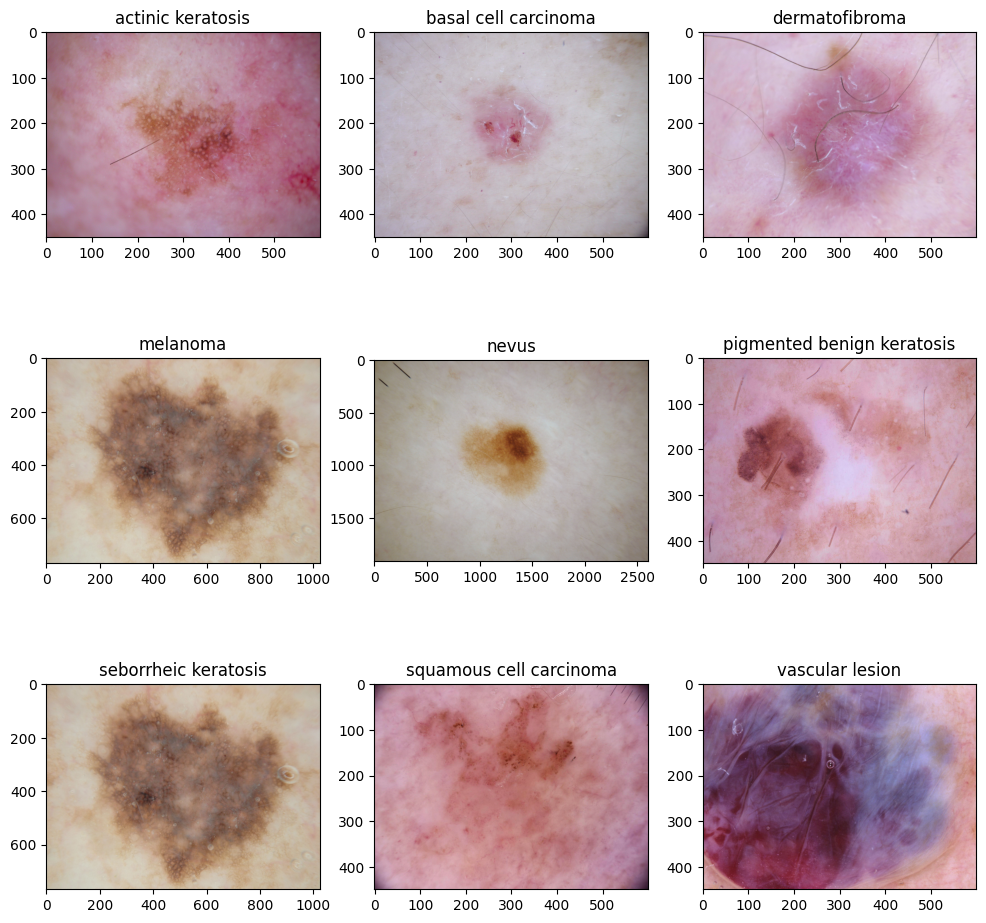

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12,12))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1).
#### Note: If you are using the latest version of tensorflow, you will likey encounter this error. Tensorflow no longer have 'experimental' module under the 'keras.layers' module. You can access the preprocessing libraries directly under tf.keras.layers instead of tf.keras.layers.experimental.preprocessing.

#### The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
num_classes=9

model = Sequential([
                    layers.Rescaling(1.0/255, input_shape = (180, 180, 3))
])
model.add(Conv2D(32, kernel_size=(3,3),padding = 'Same',
                     activation= 'relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3),padding = 'Same', 
                     activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),padding = 'Same', 
                     activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

/home/dsilvaj/miniconda3/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/dsilvaj/miniconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/home/dsilvaj/miniconda3/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1726563537.721321   96377 service.cc:146] XLA service 0x7f3db4018390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726563537.721397   96377 service.cc:154]   StreamExecutor device (0): NVIDIA T1200 Laptop GPU, Compute Capability 7.5
2024-09-17 14:28:57.750253: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-17 14:28:59.387080: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.0729 - loss: 6.2366

I0000 00:00:1726563546.708178   96377 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.1550 - loss: 3.9278 - val_accuracy: 0.1678 - val_loss: 2.0503
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2803 - loss: 1.9147 - val_accuracy: 0.3937 - val_loss: 1.7376
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3813 - loss: 1.6822 - val_accuracy: 0.4116 - val_loss: 1.6347
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4301 - loss: 1.5863 - val_accuracy: 0.4407 - val_loss: 1.6530
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4410 - loss: 1.5460 - val_accuracy: 0.4206 - val_loss: 1.5553
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.4855 - loss: 1.4525 - val_accuracy: 0.5145 - val_loss: 1.4579
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5111 - loss: 1.3965 - val_accuracy: 0.5347 - val_loss: 1.4439
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5173 - loss: 1.3282 - val_accuracy: 0.4541 - val_loss: 

### Visualizing training results

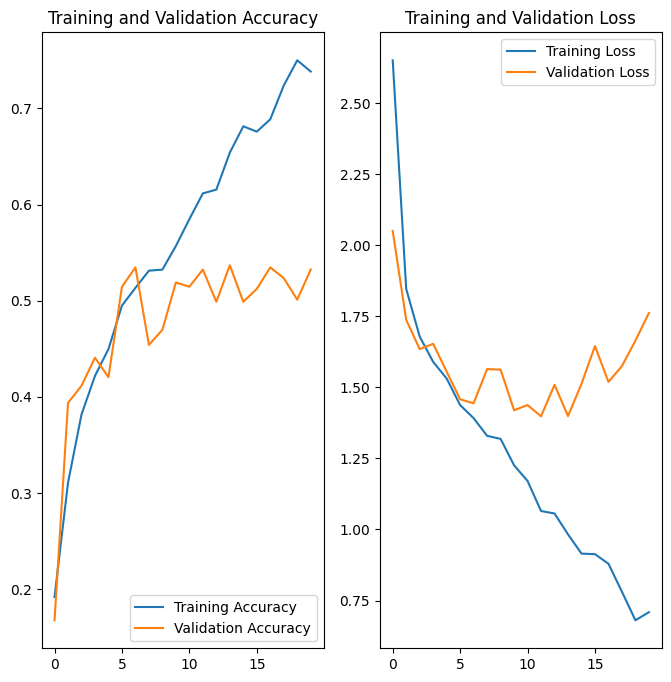

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Finding on the first base model
##### The model is clearly overfitting

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
# Apply `data_augmentation` to the training images.
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


2024-09-17 14:30:58.968077: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


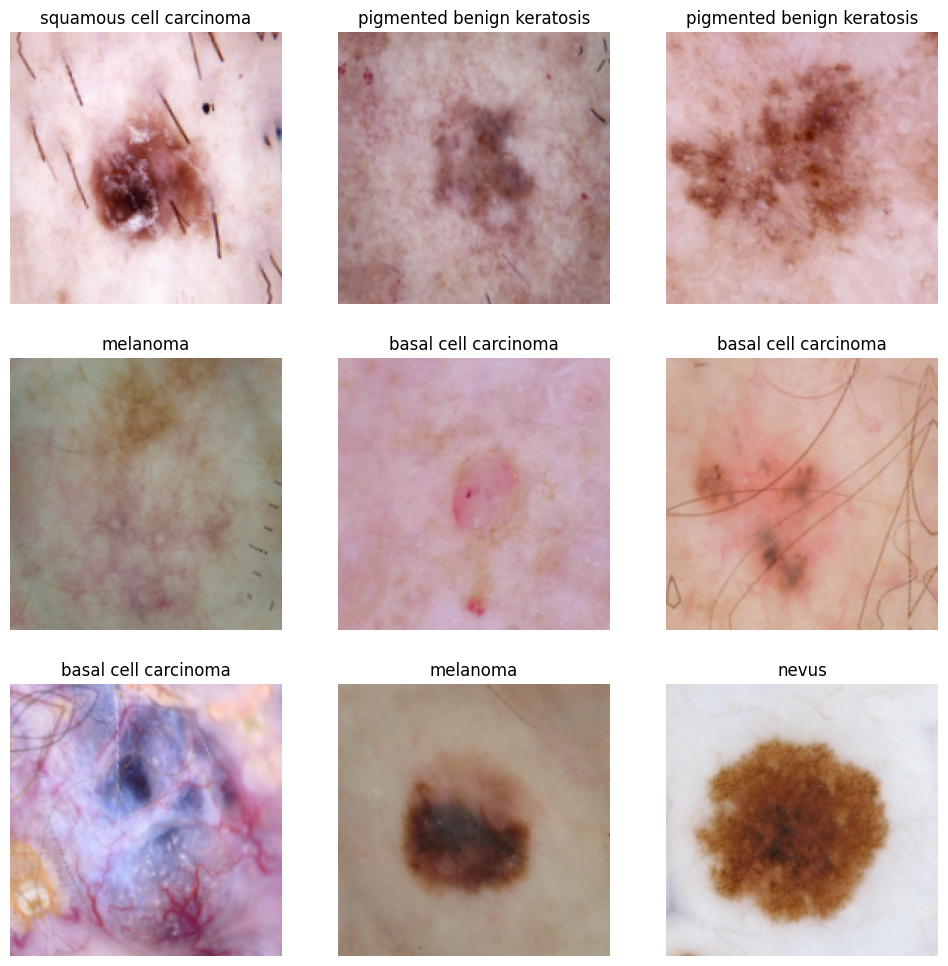

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes=9

model = Sequential([
                    layers.Rescaling(1.0/255, input_shape = (180, 180, 3))
])
model.add(Conv2D(32, kernel_size=(3,3),padding = 'Same',
                     activation= 'relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3),padding = 'Same', 
                     activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),padding = 'Same', 
                     activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))



### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.1670 - loss: 3.9125 - val_accuracy: 0.2170 - val_loss: 2.1332
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2152 - loss: 2.0310 - val_accuracy: 0.2707 - val_loss: 1.9835
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.2802 - loss: 1.9160 - val_accuracy: 0.3535 - val_loss: 1.8540
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.3646 - loss: 1.7566 - val_accuracy: 0.4139 - val_loss: 1.6817
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.4434 - loss: 1.6202 - val_accuracy: 0.4183 - val_loss: 1.6399
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.4263 - loss: 1.5636 - val_accuracy: 0.4609 - val_loss: 1.5637
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.4545 - loss: 1.5375 - val_accuracy: 0.4855 - val_loss: 1.5318
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.4600 - loss: 1.5351 - val_accuracy: 0.4609 - v

### Visualizing the results

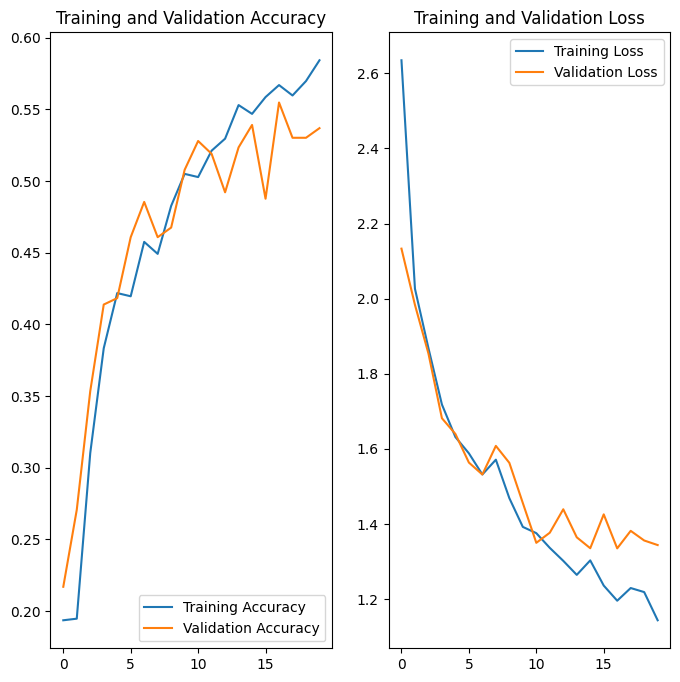

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Finding from Second Model
#### We can observe that the overfitting problem is solved with data augmentation
#### We can observe an improvement in the validation accuracy and validation loss

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

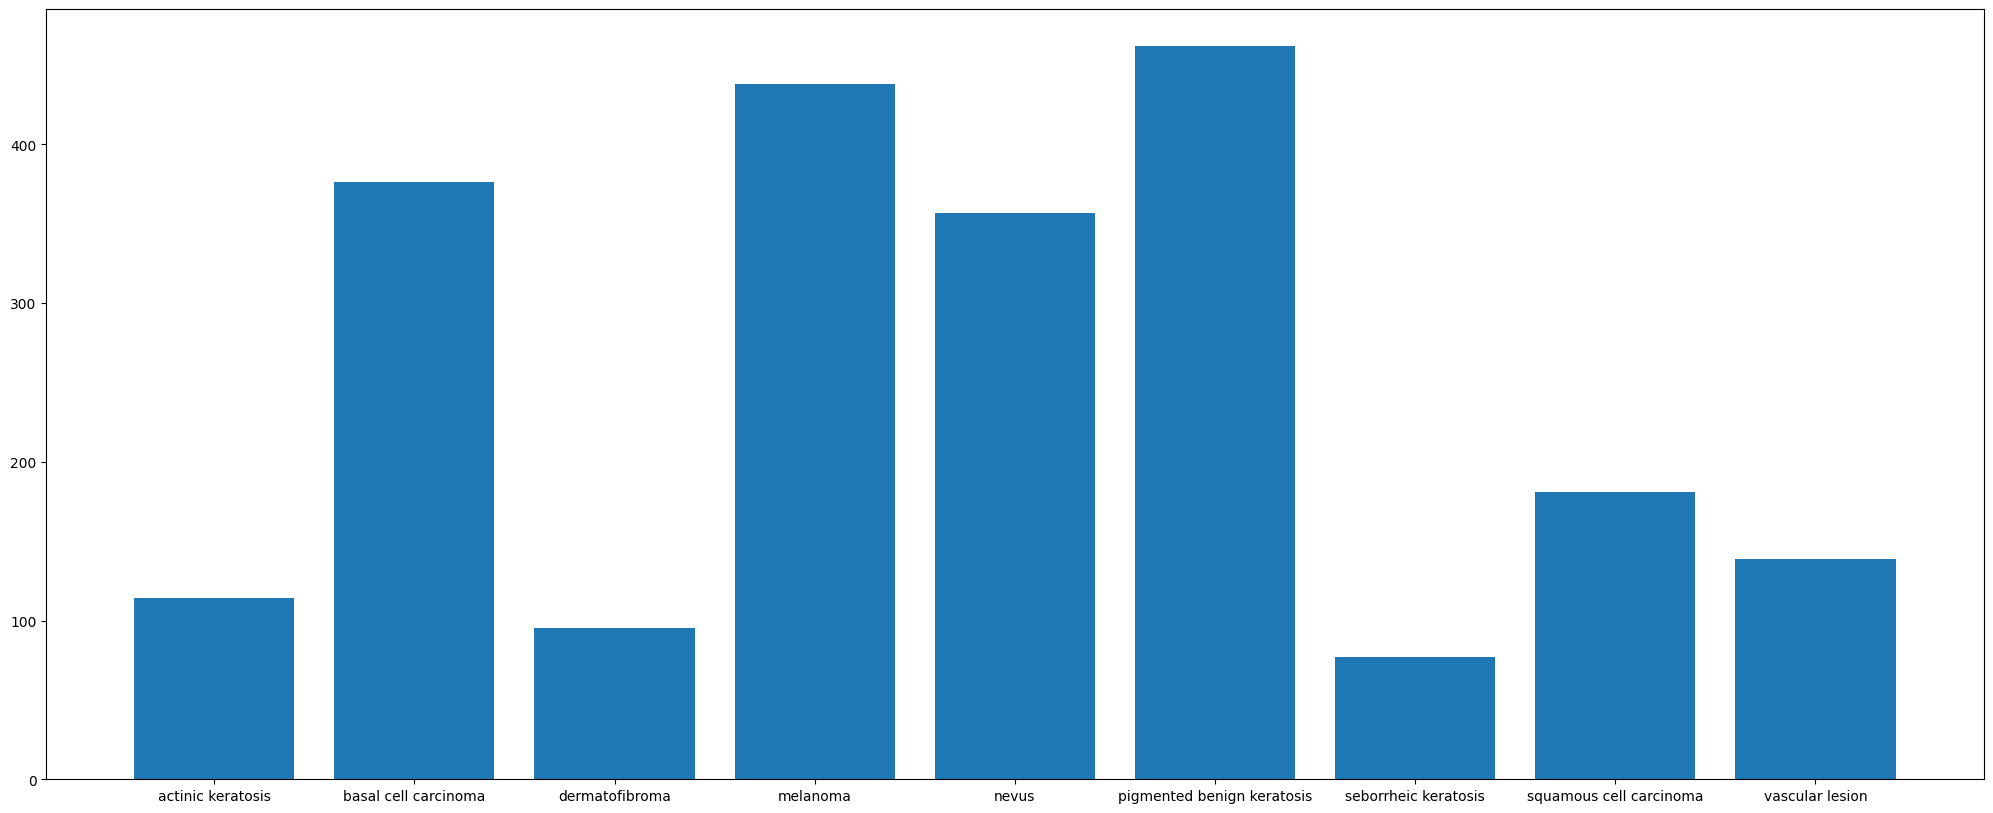

In [23]:
## Your code goes here.
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
##### Answer: seborrheic keratosis.
#### - Which classes dominate the data in terms proportionate number of samples?
##### Answer: pigmented benign keratosis, melanoma, basal cell carcinoma and nevus.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="./data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E9C1F1990>: 100%|█| 500/500 [00:02<00:00, 234.47 Samples


Initialised with 376 image(s) found.
Output directory set to ./data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3EC3FA9840>: 100%|█| 500/500 [00:01<00:00, 250.06 Samples


Initialised with 95 image(s) found.
Output directory set to ./data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3E9FF03430>: 100%|█| 500/500 [00:03<00:


Initialised with 438 image(s) found.
Output directory set to ./data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3E9C1CA920>: 100%|█| 500/500 [00:20<00:00, 24.40 Samples


Initialised with 357 image(s) found.
Output directory set to ./data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F3E9C1B07C0>: 100%|█| 500/500 [00:11<00


Initialised with 462 image(s) found.
Output directory set to ./data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E9FF00A00>: 100%|█| 500/500 [00:02<00:00, 245.50 Samples


Initialised with 77 image(s) found.
Output directory set to ./data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3EC3F6E710>: 100%|█| 500/500 [00:04<00:00, 117.02 Sample


Initialised with 181 image(s) found.
Output directory set to ./data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E9FF016C0>: 100%|█| 500/500 [00:02<00:00, 247.16 Samples


Initialised with 139 image(s) found.
Output directory set to ./data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3E9C1F3490>: 100%|█| 500/500 [00:01<00:00, 273.59 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['data/Train/vascular lesion/output/vascular lesion_original_ISIC_0029404.jpg_a8ca44a8-b167-4a61-a73d-f1ab97b35148.jpg',
 'data/Train/vascular lesion/output/vascular lesion_original_ISIC_0032076.jpg_d2775798-ad0d-428e-b471-7b26c9fdfd67.jpg',
 'data/Train/vascular lesion/output/vascular lesion_original_ISIC_0026092.jpg_bb92b2cd-c492-49e9-a7b1-693a54e6e1f6.jpg',
 'data/Train/vascular lesion/output/vascular lesion_original_ISIC_0028146.jpg_04b70558-b0df-4925-bb67-c661d58ce1a7.jpg',
 'data/Train/vascular lesion/output/vascular lesion_original_ISIC_0028146.jpg_c93f572a-344a-42a0-9674-047f1494ace1.jpg',
 'data/Train/vascular lesion/output/vascular lesion_original_ISIC_0029514.jpg_2b8d8be1-44bc-4d89-abe9-dd980b330ca4.jpg',
 'data/Train/vascular lesion/output/vascular lesion_original_ISIC_0025606.jpg_33a604d6-81a5-4112-8714-dff7ca9f4596.jpg',
 'data/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_37656e8d-ad2e-47eb-a9cb-e9cda76fa68c.jpg',
 'data/Train/vascular lesion/out

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [43]:
new_df['Label'].value_counts()

Label
vascular lesion               500
actinic keratosis             500
melanoma                      500
seborrheic keratosis          500
nevus                         500
basal cell carcinoma          500
pigmented benign keratosis    500
squamous cell carcinoma       500
dermatofibroma                500
Name: count, dtype: int64

In [47]:
new_df['Path']

0       data/Train/vascular lesion/output/vascular les...
1       data/Train/vascular lesion/output/vascular les...
2       data/Train/vascular lesion/output/vascular les...
3       data/Train/vascular lesion/output/vascular les...
4       data/Train/vascular lesion/output/vascular les...
                              ...                        
4495    data/Train/dermatofibroma/output/dermatofibrom...
4496    data/Train/dermatofibroma/output/dermatofibrom...
4497    data/Train/dermatofibroma/output/dermatofibrom...
4498    data/Train/dermatofibroma/output/dermatofibrom...
4499    data/Train/dermatofibroma/output/dermatofibrom...
Name: Path, Length: 4500, dtype: object

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [48]:
data_dir_train=pathlib.Path("./data/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [50]:
num_classes=9

model = Sequential([
                    layers.Rescaling(1.0/255, input_shape = (180, 180, 3))
])
model.add(Conv2D(32, kernel_size=(3,3),padding = 'Same',
                     activation= 'relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3),padding = 'Same', 
                     activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),padding = 'Same', 
                     activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

/home/dsilvaj/miniconda3/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/dsilvaj/miniconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [52]:
epochs = 50
## Your code goes here, use 50 epochs.
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/home/dsilvaj/miniconda3/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.1766 - loss: 2.6504 - val_accuracy: 0.2784 - val_loss: 1.8607
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.3759 - loss: 1.6390 - val_accuracy: 0.4358 - val_loss: 1.5209
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.4662 - loss: 1.4078 - val_accuracy: 0.4573 - val_loss: 1.4338
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.5240 - loss: 1.2850 - val_accuracy: 0.5264 - val_loss: 1.3155
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.5706 - loss: 1.1834 - val_accuracy: 0.5553 - val_loss: 1.1919
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.6161 - loss: 1.0656 - val_accuracy: 0.5672 - val_loss: 1.1691
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.6403 - loss: 0.9898 - val_accuracy: 0.6221 - val_loss: 1.0500
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.6841 - loss: 0.8917 - val_accura

#### **Todo:**  Visualize the model results

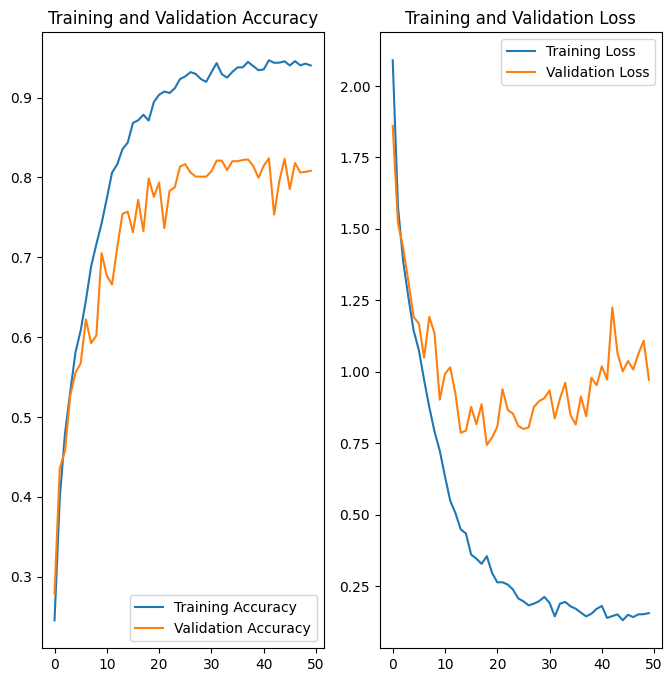

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter